In [ ]:
# import packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.0.1
    Uninstalling pip-25.0.1:
      Successfully uninstalled pip-25.0.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 10.2 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 9.8 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 555.5/555.5 kB 7.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 11.9 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.2/37.2 MB 11.8 MB/s  0:00:03m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 9.9 MB/s  0:00:02m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 [shap]2m11/12 [shap]]]learn]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 2724

### Import data

In [3]:
DF_PATH = "mod04_data/sample.csv"
df = pd.read_csv(DF_PATH)

### Separate data by independent (X) and dependent (y) variables

In [4]:
X = df[["income", "education_years", "zipcode_score"]]
y = df["target"]

### Split the data into a _training_ set (to build a model) and _test_ set (to validate a model)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed
)

### Build a model on the training set

In [6]:
model = RandomForestRegressor(
    n_estimators=200,
    random_state=seed
)
model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

### Use SHAP to explain the model on test data

In [7]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

 99%|===================| 1483/1500 [00:59<00:00]        

This will allow us to see which variables are most important to predicting the outcome.

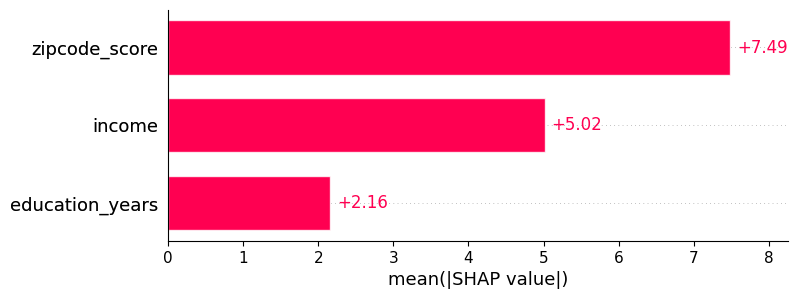

In [8]:
shap.plots.bar(shap_values)

### Import the `group` variable, which was **not** used in training this model.

In [9]:
X_test_with_group = X_test.copy()
X_test_with_group["group"] = df.loc[X_test.index, "group"]

### Look at the difference in SHAP values between the two groups across the variables used in the model.

In [10]:
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
shap_df["group"] = X_test_with_group["group"].values

shap_df.groupby("group").mean()

,income,education_years,zipcode_score
group,,,
0,1.085462,-0.172202,5.865217
1,1.019984,-0.193786,-6.860764


### Let's put `group` and `zipcode_score` in the same plot

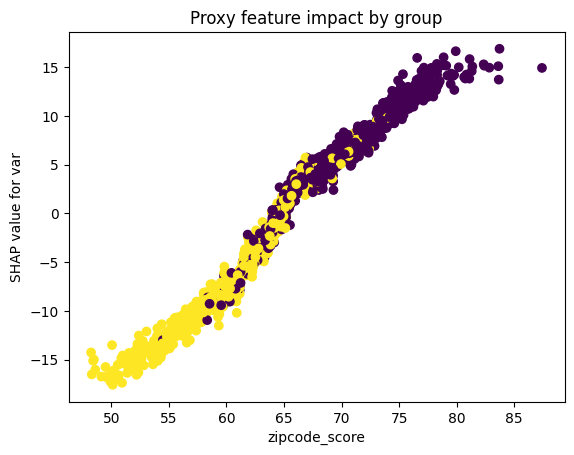

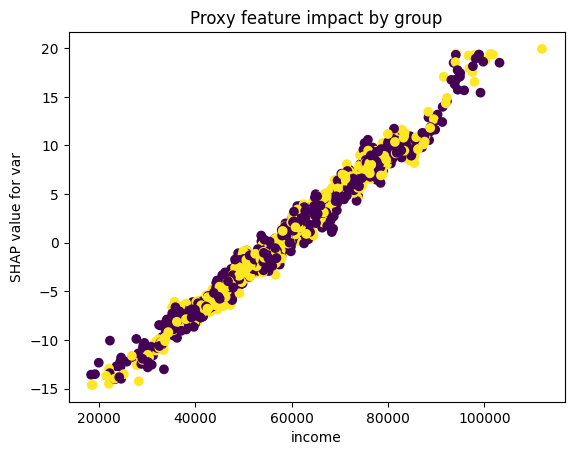

In [13]:
def plot_shap(var):
    # Extract SHAP values for the feature
    shap_var = shap_values[:, var].values

    # Plot the values of each group using different colors
    plt.figure()
    plt.scatter(
        X_test[var],
        shap_var,
        c=X_test_with_group["group"]
    )
    plt.xlabel(var)
    plt.ylabel(f"SHAP value for var")
    plt.title("Proxy feature impact by group")
    plt.show()

plot_shap("zipcode_score")
plot_shap("income")

# Discussion Questions

### What is a _SHAP_ (or Shapley) value? 

Type your answer here
A SHAP value measures how much each feature contributes to a model's prediction compared to the average prediction. A positive SHAP value increases the predicted outcome while a negative one decreases it.

### Suppose you built this model and then it is peer reviewed by another entity. If the reviewer asks whether you used the variable `group` in your model, what would your answer be?

Type your answer here
The group variable was not used when training the model, instead the model was trained only using income income, education_years, and zipcode_score. The group variable wasn't introduced until later solely for analysis purposes. It was used to evaluate whether the model exhibits potential bias across demographic groups.

### If the reviewer asks whether the outcome of your model is correlated with `group`, what would your answer be?

Type your answer here
The model's outcomes do appear to be correlated with group even though the group variable was not explicitly used in training. It can be seen through SHAP value anlysis that there are systematic differences in feature impact between groups, prominently for zipcode_score. This could mean that some features may act as proxy variables that encode information related to group membership indirectly.

### Construct a "proxy feature impact by group" plot for `income`. How is this plot different from the one for `zipcode_score`?

In [ ]:
plot_shap("income")

SyntaxError: invalid syntax (3608324597.py, line 1)

In [ ]:
plot_shap("income")

Type your answer here.
The proxy feature impact plot for income shows substantially more overlap between the two groups versus zipcode_score's plot. While income does influence the model's predictions, the separation between demographic groups is less distinct. We can see that zipcode_score shows clearer clustering by grouping. This indicates that it functions as a stronger proxy for group membership than income.

### If, instead, you were the **reviewer**, what other questions might you ask the person who built this model? Give at least two.

Type your answer here.
1. What safeguards exist to prevent unfair decisions when this model is used in real life applications?
2. Do prediction errors differ across demographic groups and does the model perform worse for one group compared to another?